In [150]:
import gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Create the Taxi-v3 environment
env = gym.make('Taxi-v3', render_mode='ansi')

# Set a fixed random seed for reproducibility
seed = 42
env.reset(seed=seed)
np.random.seed(seed)
random.seed(seed)

# Initialize Q-tables
q_table_shape = [env.observation_space.n, env.action_space.n]
q_table_qlearning = np.zeros(q_table_shape)
q_table_sarsa = np.zeros(q_table_shape)

# Set hyperparameters
learning_rate = 0.25  
discount_factor = 0.995  
initial_epsilon = 1.0 
min_epsilon = 0.05  
epsilon_decay = 0.995
temperature = 1.5  
training_episodes = 2000  
max_steps = 1750  

### Greedy Strategy
$$ a = \arg\max_{a} Q(s, a) $$

### Epsilon-Greedy Strategy
$$a = 
\begin{cases} 
\text{random action} & \text{with probability } \epsilon \\
\arg\max_{a} Q(s, a) & \text{with probability } 1 - \epsilon 
\end{cases}$$

### Softmax Strategy
$$ P(a|s) = \frac{\exp(Q(s, a) / T)}{\sum_{b} \exp(Q(s, b) / T)} $$

In [151]:
def choose_action(state, q_table, strategy, epsilon, temperature):
    if strategy == "greedy":
        return np.argmax(q_table[state])
    elif strategy == "epsilon-greedy":
        if random.uniform(0, 1) < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(q_table[state])
    elif strategy == "softmax":
        q_values = q_table[state]
        exp_q = np.exp(q_values / temperature)
        probabilities = exp_q / np.sum(exp_q)
        return np.random.choice(len(q_values), p=probabilities)

### Q-Learning Update
$$ Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right] $$

### SARSA Update
$$ Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma Q(s', a') - Q(s, a) \right] $$

In [152]:
def update_q_table(q_table, state, action, reward, next_state, next_action, alpha, gamma, algorithm):
    if algorithm == "qlearning":
        next_max = np.max(q_table[next_state])
        q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * next_max - q_table[state, action])
    elif algorithm == "sarsa":
        q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * q_table[next_state, next_action] - q_table[state, action])
    return q_table

def train(env, q_table, episodes, alpha, gamma, epsilon, min_epsilon, epsilon_decay, temperature, max_steps, algorithm, strategy):
    rewards_per_episode = []
    steps_per_episode = []
    for episode in tqdm(range(episodes)):
        state = env.reset()[0]
        done = False
        total_reward = 0
        steps = 0

        action = choose_action(state, q_table, strategy, epsilon, temperature)

        while not done and steps < max_steps:
            next_state, reward, done, truncated, info = env.step(action)
            next_action = choose_action(next_state, q_table, strategy, epsilon, temperature)

            q_table = update_q_table(q_table, state, action, reward, next_state, next_action, alpha, gamma, algorithm)

            state = next_state
            action = next_action
            total_reward += reward
            steps += 1

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)
    return q_table, rewards_per_episode, steps_per_episode

#### Choosing different strategies during training and observe the performance of different strategies during testing.

100%|██████████| 2000/2000 [00:00<00:00, 3867.55it/s]


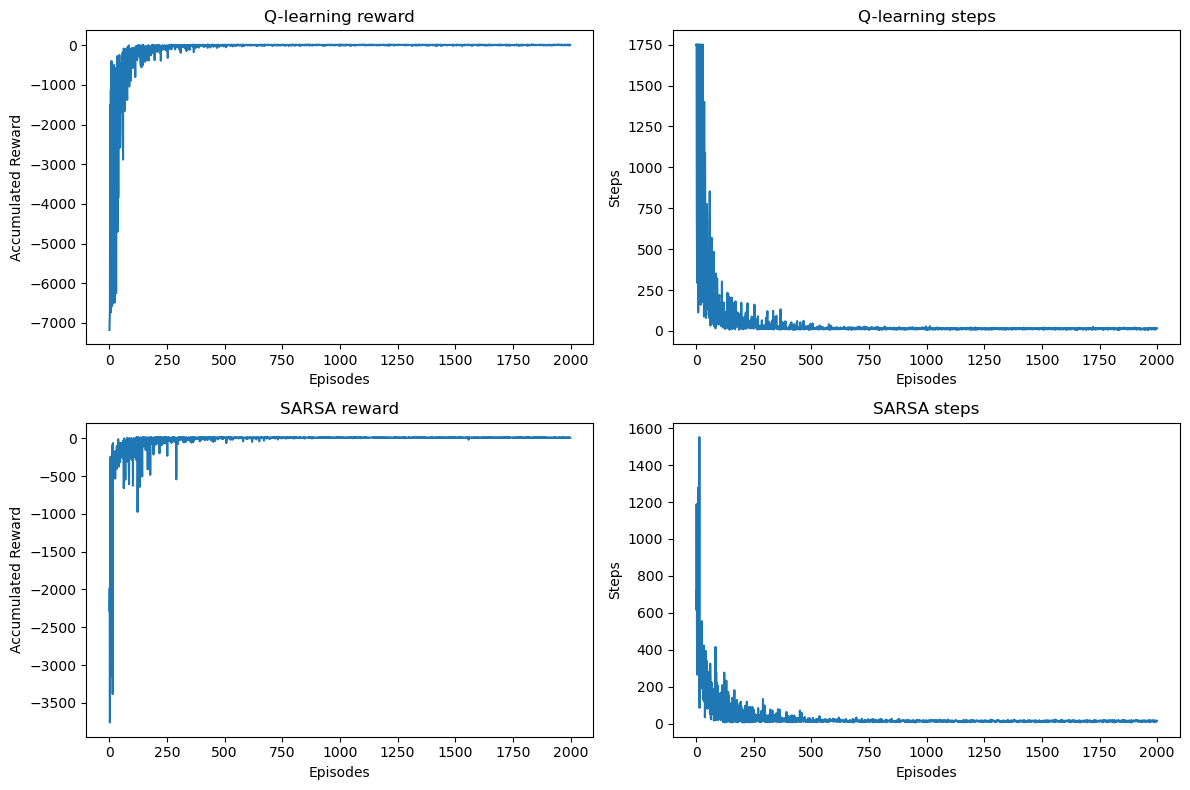

In [153]:
# Train Q-learning
strategy_qlearning = "epsilon-greedy"  # Options: "greedy", "epsilon-greedy", "softmax"
q_table_qlearning, rewards_qlearning, steps_qlearning = train(env, np.copy(q_table_qlearning), training_episodes, learning_rate, discount_factor, initial_epsilon, min_epsilon, epsilon_decay, temperature, max_steps, "qlearning", strategy_qlearning)

# Train SARSA
strategy_sarsa = "greedy"  # Options: "greedy", "epsilon-greedy", "softmax"
q_table_sarsa, rewards_sarsa, steps_sarsa = train(env, np.copy(q_table_sarsa), training_episodes, learning_rate, discount_factor, initial_epsilon, min_epsilon, epsilon_decay, temperature, max_steps, "sarsa", strategy_sarsa)


# Plot accumulated rewards and steps
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(rewards_qlearning)
axes[0, 0].set_title('Q-learning reward')
axes[0, 0].set_xlabel('Episodes')
axes[0, 0].set_ylabel('Accumulated Reward')

axes[0, 1].plot(steps_qlearning)
axes[0, 1].set_title('Q-learning steps')
axes[0, 1].set_xlabel('Episodes')
axes[0, 1].set_ylabel('Steps')

axes[1, 0].plot(rewards_sarsa)
axes[1, 0].set_title('SARSA reward')
axes[1, 0].set_xlabel('Episodes')
axes[1, 0].set_ylabel('Accumulated Reward')

axes[1, 1].plot(steps_sarsa)
axes[1, 1].set_title('SARSA steps')
axes[1, 1].set_xlabel('Episodes')
axes[1, 1].set_ylabel('Steps')

plt.tight_layout()
plt.show()

# Save Q-tables
np.save('q_table_qlearning.npy', q_table_qlearning)
np.save('q_table_sarsa.npy', q_table_sarsa)

#### Testing and rendering the task process based on the Q-tables saved from training

In [154]:
# Test the trained agent
def test_agent(env, q_table, episodes, max_steps):
    total_rewards = 0
    total_steps = 0
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        steps = 0
        while not done and steps < max_steps:
            action = np.argmax(q_table[state])
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            total_rewards += reward
            steps += 1
        total_steps += steps
    avg_reward = total_rewards / episodes
    avg_steps = total_steps / episodes
    return avg_reward, avg_steps

# Test Q-learning and SARSA
avg_reward_qlearning, avg_steps_qlearning = test_agent(env, q_table_qlearning, 100, 100)
avg_reward_sarsa, avg_steps_sarsa = test_agent(env, q_table_sarsa, 100, 100)

print(f'Q-learning - Average Reward: {avg_reward_qlearning}, Average Steps: {avg_steps_qlearning}')
print(f'SARSA - Average Reward: {avg_reward_sarsa}, Average Steps: {avg_steps_sarsa}')

Q-learning - Average Reward: 8.06, Average Steps: 12.94
SARSA - Average Reward: 8.11, Average Steps: 12.89


In [155]:
# Function to render the trained agent's policy
def render_policy(env, q_table, max_steps=100):
    state = env.reset()[0] 
    done = False  
    steps = 0  
    total_reward = 0  

    # Render the initial state
    print(env.render())
    print(f'Step: {steps}, State: {state}, Action: N/A, Reward: 0, Total Accumulated Reward: {total_reward}')

    while not done and steps < max_steps:
        action = np.argmax(q_table[state])  # greedy 
        next_state, reward, done, truncated, info = env.step(action)  
        state = next_state  
        total_reward += reward  
        steps += 1  
        print(env.render())  
        print(f'Step: {steps}, State: {state}, Action: {action}, Reward: {reward}, Total Accumulated Reward: {total_reward}')  

    return total_reward, steps  

# Render the policy for the Q-learning agent
print("Q-learning Policy:")
total_reward_qlearning, total_steps_qlearning = render_policy(env, q_table_qlearning)
print(f'Q-learning Total Reward: {total_reward_qlearning}, Total Steps: {total_steps_qlearning}')

# Render the policy for the SARSA agent
print("SARSA Policy:")
total_reward_sarsa, total_steps_sarsa = render_policy(env, q_table_sarsa)
print(f'SARSA Total Reward: {total_reward_sarsa}, Total Steps: {total_steps_sarsa}')

Q-learning Policy:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Step: 0, State: 383, Action: N/A, Reward: 0, Total Accumulated Reward: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 1, State: 363, Action: 3, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 2, State: 263, Action: 1, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 3, State: 243, Action: 3, Reward: -1, Total Accumulated Reward: -3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 4, State: 223, Action: 3, Reward: -1, Total Accumulated Reward: -4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 5, State: 123, Action: 1, Reward: -1, Total Accumula